In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from tqdm import tqdm

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']=''

In [4]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [8]:
template_data_path = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [9]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

In [7]:
template_data = template_data[:,4:164,8:200,8:168]
template_data.shape

torch.Size([1, 76, 88, 72])

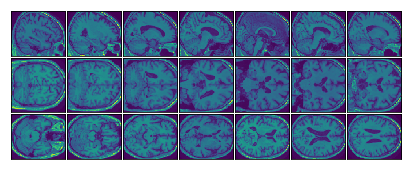

In [10]:
fig, axes = plt.subplots(3,7, figsize=(7,2.75), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(7):
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

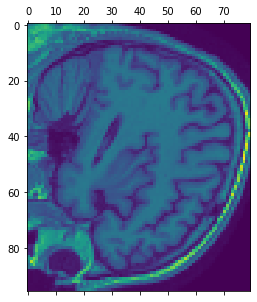

In [11]:
plt.matshow(template_data[0][60])
plt.show()

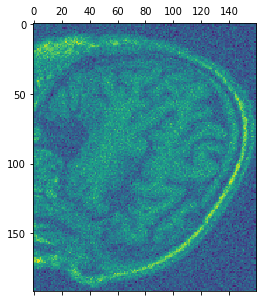

In [21]:
# Illustraion of the noise added to the discriminator

template_data /= template_data.max()
plt.matshow(template_data[0][30] + torch.normal(torch.zeros(template_data[0][30].shape), 0.1))
plt.show()

In [67]:
caps_info = pd.read_csv('/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:
caps_info

age diagnosis  MMSE
participant_id   session_id                      
sub-ADNI002S0295 ses-M00     84.8        CN  28.0
                 ses-M06     85.3        CN  28.0
                 ses-M12     85.8        CN  30.0
                 ses-M24     87.0        CN  29.0
                 ses-M36     87.8        CN  28.0
...                           ...       ...   ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0
                 ses-M12     75.4       NaN   NaN
                 ses-M24     76.4       NaN  30.0
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0
sub-ADNI941S6854 ses-M00     86.2        AD  30.0

[16319 rows x 3 columns]

In [ ]:
path_imaging_data = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}

number_of_patients = 3000
i = 0 

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    if caps_info.loc[sub]['MMSE'].between(5, 26).any():
        i += 1
        for ses in ses_lst:

            ses_path = os.path.join(sub_path, ses)
            filename = 'deeplearning_prepare_data/image_based/t1_linear/' + sub + '_' + ses + '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
            ses_data_path = os.path.join(ses_path, filename)

            if (caps_info.loc[(sub,ses)]['diagnosis'] in ['MCI', 'AD']):
                # Load the data
                ses_torch = torch.load(ses_data_path)
                if ses_torch.isnan().any() or torch.tensor([caps_info.loc[(sub,ses)]['age']]).isnan():
                    continue
                # Subsample
                ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
                # Normalize
                ses_torch = ses_torch/ses_torch.max()

                data_dict['data'] = torch.cat((data_dict['data'], ses_torch.float()))
                data_dict['timepoints'] = torch.cat((data_dict['timepoints'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
                data_dict['labels'] = torch.cat((data_dict['labels'], torch.tensor([int(sub_id)])))

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(1e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless timepointss) and delete the template data
data_dict['data'], data_dict['timepoints'], data_dict['labels'] = data_dict['data'][1:], data_dict['timepoints'][1:], data_dict['labels'][1:]

data_dict

/tmp/ipykernel_3906492/1296045355.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict = {'data':torch.tensor(template_data), 'timepoints':torch.ones(1), 'labels':torch.IntTensor([1])}
 67%|███████████████████████▌           | 1518/2254 [1:04:14<1:18:36,  6.41s/it]

In [31]:
print(f"There are {data_dict['data'].shape[0]} visits with a total of {data_dict['data'].shape[1]*data_dict['data'].shape[2]*data_dict['data'].shape[3]} dimentions")

There are 4569 visits with a total of 614400 dimentions


In [ ]:
torch.save(data_dict, 'ADNI_MCI_AD')

### Remove the visits where timepoint is nan

In [29]:
data_dict = torch.load('ADNI_MCI_AD')

In [32]:
for i in range(len(data_dict['timepoints'])):
    if data_dict['timepoints'][i].isnan():
        print(i)

In [21]:
data_dict['timepoints'] = torch.cat([data_dict['timepoints'][:3606], data_dict['timepoints'][3607:5256], data_dict['timepoints'][5257:5346], data_dict['timepoints'][5348:7139], data_dict['timepoints'][7140:]])
data_dict['labels'] = torch.cat([data_dict['labels'][:3606], data_dict['labels'][3607:5256], data_dict['labels'][5257:5346], data_dict['labels'][5348:7139], data_dict['labels'][7140:]])
data_dict['data'] = torch.cat([data_dict['data'][:3606], data_dict['data'][3607:5256], data_dict['data'][5257:5346], data_dict['data'][5348:7139], data_dict['data'][7140:]])

In [22]:
for i in range(len(data_dict['timepoints'])):
    if data_dict['timepoints'][i].isnan():
        print(i)

In [8]:
torch.save(data_dict, 'ADNI_full_no_nan')

### Reorder the ids

In [41]:
data_dict = torch.load('ADNI_MCI_AD')

In [42]:
already_seen = []
group = []
idx = -1

for i in range(len(data_dict['labels'])):
    if data_dict['labels'][i] not in already_seen:
        already_seen.append(data_dict['labels'][i])
        idx += 1
    group.append(idx)

In [43]:
data_dict['RID'] = data_dict['labels']
data_dict['labels'] = torch.tensor(group)

In [44]:
torch.save(data_dict, 'ADNI_MCI_AD')

## Load the saved data and take only a subset to allow faster training

In [5]:
data = torch.load('ADNI_full')

In [9]:
data['data'].shape

torch.Size([3959, 80, 96, 80])

In [12]:
data['data'].max()

tensor(1.)

In [8]:
already_seen = []
index = []
i = -1

for sub in data['labels']:
    if sub in already_seen:
        index.append(i)
    else:
        i += 1
        already_seen.append(sub)
        index.append(i)
        
torch.tensor(index) 

tensor([  0,   0,   0,  ..., 940, 941, 941])

## Mini-dataset for debugging

In [77]:
mini_data = {}
mini_data['data'] = data['data'][:10]
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(10)]
mini_data['label'] = data['label'][:10]

In [79]:
torch.save(mini_data,'mini_dataset')

## Small-dataset for testing

In [80]:
mini_data = {}
mini_data['data'] = data['data'][:100]
mini_data['ADNI_id'] = data['label'][:100]
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(100)]
mini_data['label'] = data['label'][:100]

In [81]:
torch.save(mini_data,'small_dataset')

## Large dataset for training

In [82]:
mini_data = {}
mini_data['data'] = data['data']
mini_data['timepoints'] = [(index[i], float(data['timepoints'][i])) for i in range(len(data['data']))]
mini_data['label'] = data['label']

In [83]:
torch.save(mini_data,'large_dataset')

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [45]:
data = torch.load('ADNI_CN')

(array([19., 25., 38., 73., 90., 70., 57., 41., 30., 13.]),
 array([55.1 , 58.71, 62.32, 65.93, 69.54, 73.15, 76.76, 80.37, 83.98,
        87.59, 91.2 ]),
 <BarContainer object of 10 artists>)

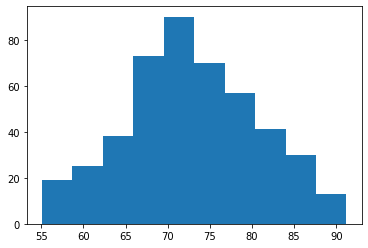

In [49]:
plt.hist(np.array(data['timepoints']))

In [50]:
data = torch.load('ADNI_MCI_AD')

(array([ 79., 181., 324., 594., 938., 988., 840., 488., 129.,   8.]),
 array([54.4 , 58.69, 62.98, 67.27, 71.56, 75.85, 80.14, 84.43, 88.72,
        93.01, 97.3 ]),
 <BarContainer object of 10 artists>)

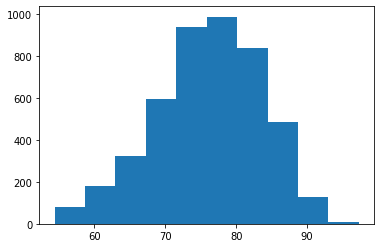

In [51]:
plt.hist(np.array(data['timepoints']))

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])

## Exploring the normalization issues

In [42]:
data_dict = torch.load('ADNI_full')

In [44]:
data = data_dict['data']

In [16]:
means_ = []
std_ = []
max_ = []  
quant_ = []

n_scans = len(data)

for i in range(n_scans):
    img = data[i]
    mean, std, maximum = float(img.mean()), float(img.std()), float(img.max())
    quant = np.quantile(img, 0.96)
    means_.append(mean)
    std_.append(std)
    max_.append(maximum)
    quant_.append(quant)

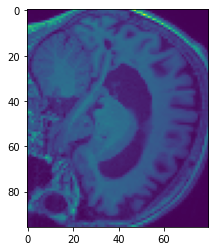

In [109]:
plt.imshow(data[254][28])

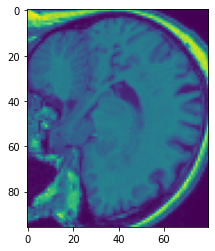

In [107]:
plt.imshow(data[255][30])

(array([2.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 5.000e+00,
        4.900e+01, 1.760e+02, 4.350e+02, 6.490e+02, 7.530e+02, 1.146e+03,
        1.946e+03, 2.230e+03, 1.639e+03, 7.390e+02, 2.180e+02, 3.700e+01,
        4.000e+00, 5.000e+00]),
 array([0.00563248, 0.02061627, 0.03560005, 0.05058383, 0.06556762,
        0.0805514 , 0.09553519, 0.11051897, 0.12550275, 0.14048654,
        0.15547032, 0.17045411, 0.18543789, 0.20042167, 0.21540546,
        0.23038924, 0.24537303, 0.26035681, 0.2753406 , 0.29032438,
        0.30530816]),
 <BarContainer object of 20 artists>)

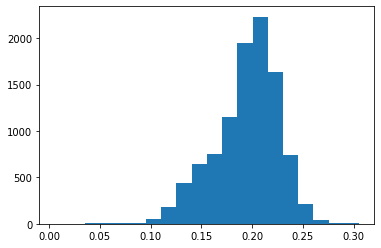

In [17]:
plt.hist(means_, bins=20)

(array([1.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 6.000e+00, 2.200e+01,
        7.100e+01, 2.060e+02, 4.340e+02, 7.950e+02, 1.386e+03, 2.174e+03,
        2.392e+03, 1.662e+03, 6.500e+02, 1.810e+02, 4.000e+01, 5.000e+00,
        3.000e+00, 3.000e+00]),
 array([0.02591413, 0.03714328, 0.04837242, 0.05960157, 0.07083071,
        0.08205986, 0.09328901, 0.10451815, 0.1157473 , 0.12697644,
        0.13820559, 0.14943473, 0.16066388, 0.17189302, 0.18312217,
        0.19435132, 0.20558046, 0.21680961, 0.22803875, 0.2392679 ,
        0.25049704]),
 <BarContainer object of 20 artists>)

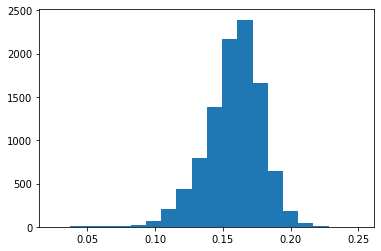

In [18]:
plt.hist(std_, bins=20)

(array([2.000e+00, 0.000e+00, 5.000e+00, 4.000e+00, 1.000e+01, 2.200e+01,
        6.800e+01, 2.260e+02, 5.930e+02, 1.269e+03, 1.949e+03, 2.243e+03,
        1.931e+03, 1.120e+03, 4.380e+02, 1.300e+02, 2.800e+01, 4.000e+00,
        2.000e+00, 3.000e+00]),
 array([0.03357463, 0.07641419, 0.11925376, 0.16209332, 0.20493288,
        0.24777244, 0.290612  , 0.33345156, 0.37629113, 0.41913069,
        0.46197025, 0.50480981, 0.54764937, 0.59048894, 0.6333285 ,
        0.67616806, 0.71900762, 0.76184718, 0.80468674, 0.84752631,
        0.89036587]),
 <BarContainer object of 20 artists>)

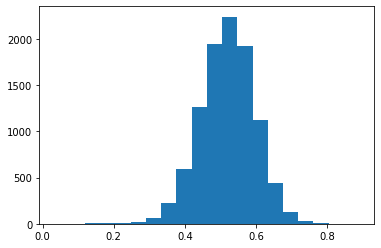

In [19]:
plt.hist(quant_, bins=20)

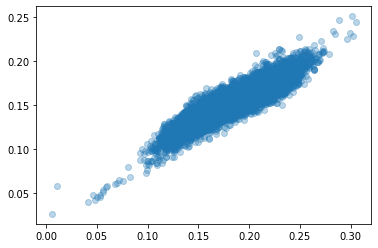

In [20]:
plt.scatter(means_, std_, alpha=.3)

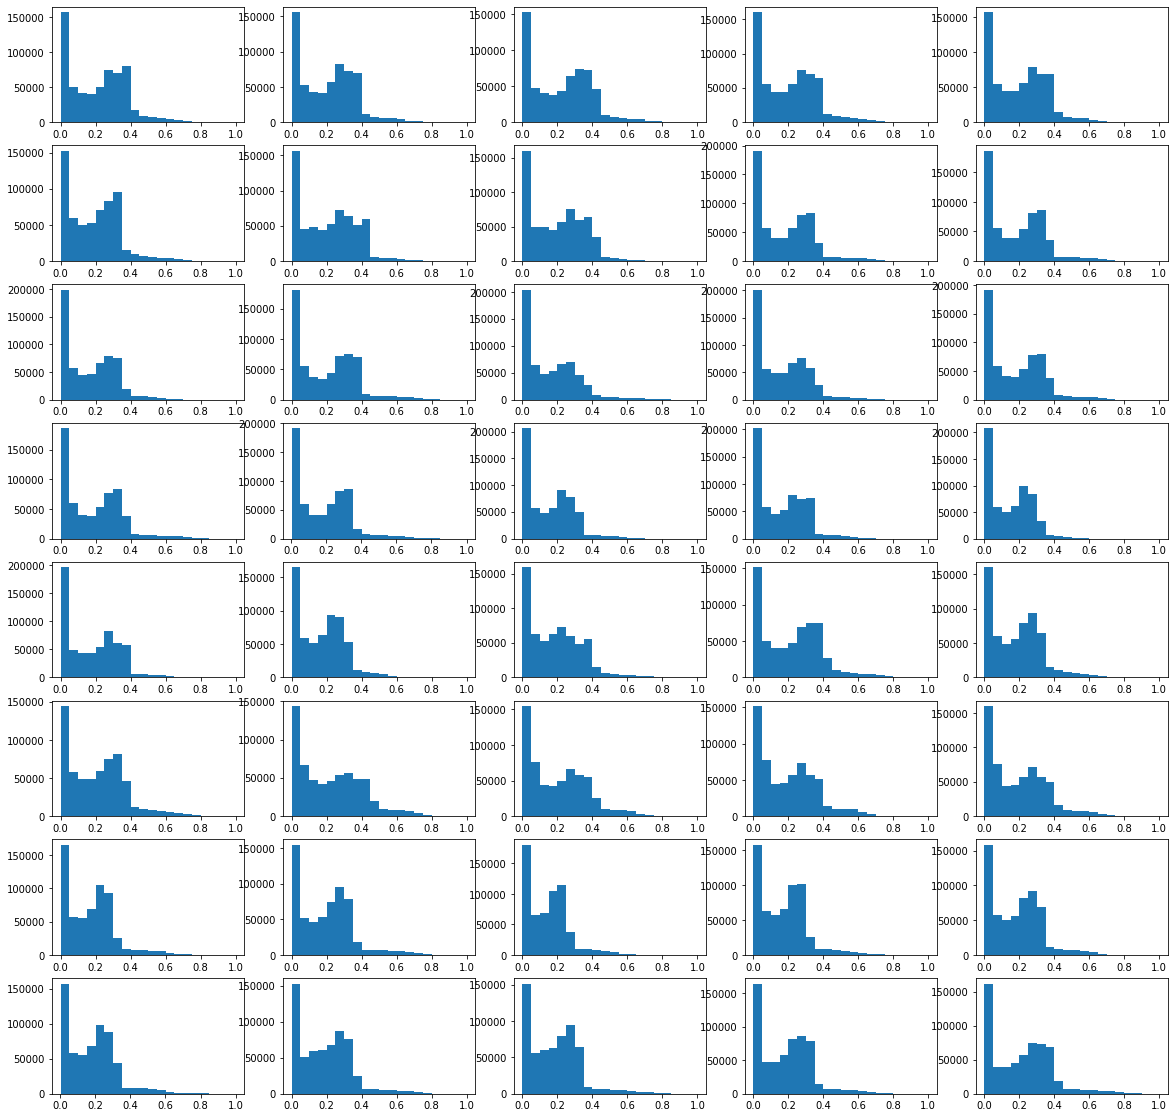

In [21]:
fig, axes = plt.subplots(8,5, figsize=(20,20))

for i in range(40):
    axes[i//5][i%5].hist(np.array(data[i]).reshape(-1), bins=20)

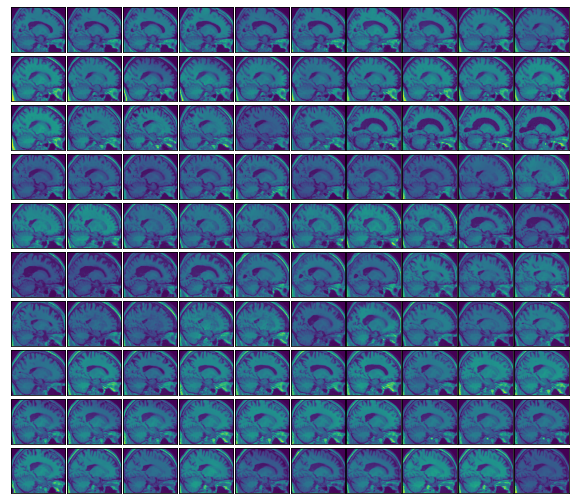

In [35]:
fig, axes = plt.subplots(10,10,figsize=(10,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(100):
    axes[i//10][i%10].imshow(np.rot90(data[i][30]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.show()

In [46]:
for i in range(n_scans):
    img = data[i]
    quant = np.quantile(img, 0.97)
    data[i] /= quant
    
data[data>1] = 1
data_dict['data'] = data
torch.save(data_dict, 'ADNI_full_norm')

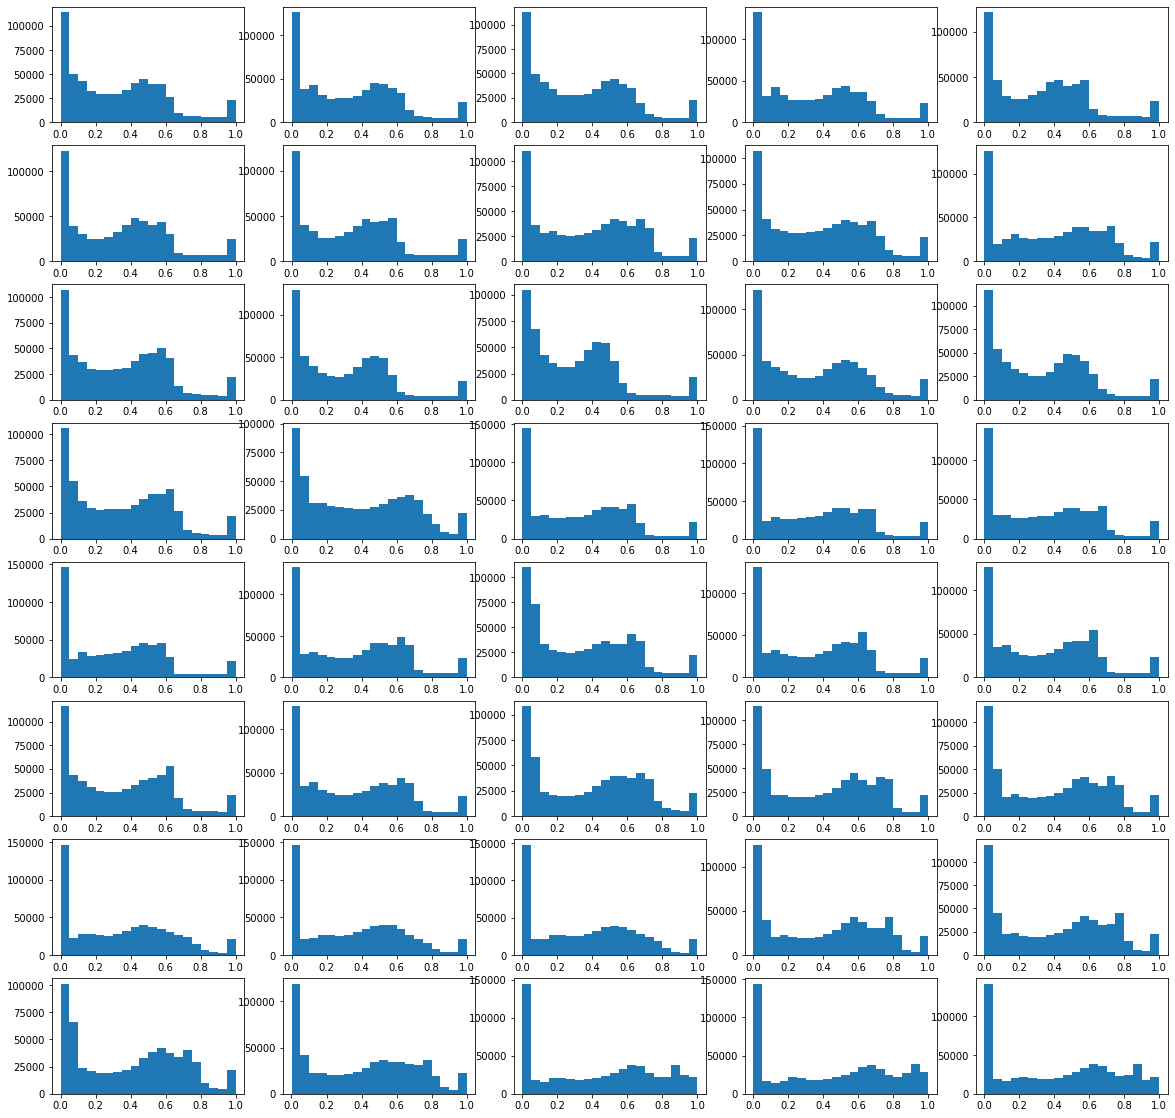

In [115]:
fig, axes = plt.subplots(8,5, figsize=(20,20))

for i in range(40):
    axes[i//5][i%5].hist(np.array(data[i+50]).reshape(-1), bins=20)

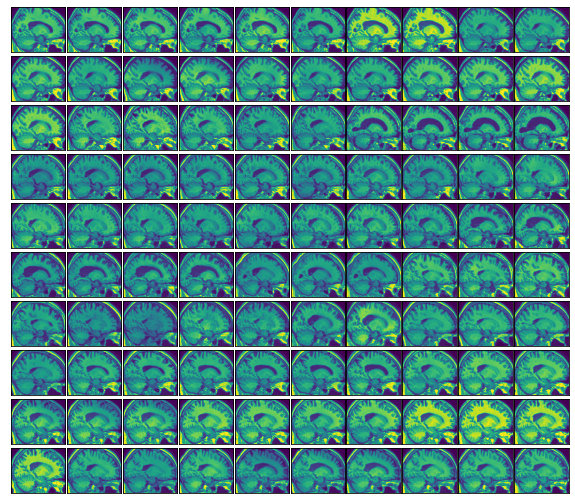

In [38]:
fig, axes = plt.subplots(10,10,figsize=(10,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

for i in range(100):
    axes[i//10][i%10].imshow(np.rot90(data[i][30]))
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.show()

In [39]:
torch_data = torch.load('ADNI_full_norm')

In [41]:
torch_data['labels']

tensor([ 619,  619,  619,  619,  729,  729,  729,  729,  729,  729,  729,  729,
         729,  729,  782,  782,  782,  782,  782,  782,  816,  816,  816,  938,
         938,  938,  938,  954,  954,  954,  954,  955,  955, 1018, 1018, 1018,
        1018])

## Locating the hippocampus

TypeError: Invalid shape (40, 80, 25) for image data

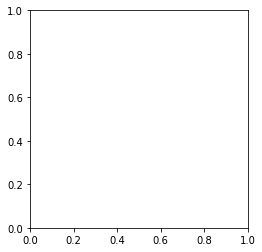

In [64]:
plt.imshow(np.rot90(data[1][:,30:70,15:40]))

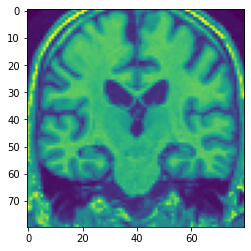

In [72]:
plt.imshow(np.rot90(data[1][:, 44]))

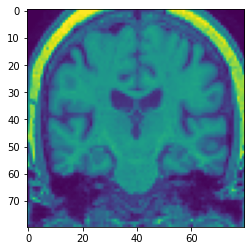

In [79]:
plt.imshow(np.rot90(data[120][:, 44]))